# RSI Mean Reversion Strategy with ATR Stop Loss Analysis

This notebook provides comprehensive analysis of the RSI mean reversion trading strategy with ATR-based stop loss implementation.

In [126]:
#1 Load Functions and Configuration

import MetaTrader5 as mt5
import pandas as pd
import numpy as np
import yaml
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
import pickle
import hashlib
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')


def calculate_rsi(prices, period=14):
    """Calculate RSI indicator"""
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    loss = loss.replace(0, 0.0001)  # Avoid division by zero
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def calculate_atr(df, period=14):
    """Calculate Average True Range (ATR)"""
    high = df['high']
    low = df['low']
    close = df['close']
    
    # Calculate True Range
    hl = high - low
    hc = abs(high - close.shift())
    lc = abs(low - close.shift())
    
    tr = pd.concat([hl, hc, lc], axis=1).max(axis=1)
    
    # Calculate ATR as exponential moving average of TR
    atr = tr.ewm(span=period, adjust=False).mean()
    return atr

def load_credentials():
    config_path = os.path.join('../config', 'credentials.yaml')
    with open(config_path, 'r') as file:
        return yaml.safe_load(file)

def load_params():
    config_path = os.path.join('../config', 'trading_params.yaml')
    with open(config_path, 'r') as file:
        return yaml.safe_load(file)

def get_cache_filename(instrument, timeframe, start_date, end_date):
    """Generate cache filename based on parameters"""
    cache_key = f"{instrument}_{timeframe}_{start_date}_{end_date}"
    cache_hash = hashlib.md5(cache_key.encode()).hexdigest()[:8]
    return f"{instrument}_{timeframe}_{cache_hash}.pkl"

def load_cached_data(cache_path):
    """Load data from cache if it exists"""
    if os.path.exists(cache_path):
        try:
            with open(cache_path, 'rb') as f:
                data = pickle.load(f)
                print(f"Loaded data from cache: {cache_path}")
                return data
        except Exception as e:
            print(f"Warning: Failed to load cache {cache_path}: {e}")
    return None

def save_to_cache(data, cache_path):
    """Save data to cache"""
    try:
        os.makedirs(os.path.dirname(cache_path), exist_ok=True)
        with open(cache_path, 'wb') as f:
            pickle.dump(data, f)
        print(f"Data cached to {cache_path}")
    except Exception as e:
        print(f"Warning: Failed to save cache {cache_path}: {e}")

def get_historical_data(instrument, timeframe, start_date, end_date, use_cache=True, cache_dir='../data/cache'):
    """Get historical data with caching support"""
    # Generate cache filename
    cache_filename = get_cache_filename(instrument, timeframe, start_date, end_date)
    cache_path = os.path.join(cache_dir, cache_filename)
    
    # Try to load from cache first
    if use_cache:
        cached_data = load_cached_data(cache_path)
        if cached_data is not None:
            return cached_data
    
    # Convert string dates to datetime
    start_dt = datetime.strptime(start_date, '%Y-%m-%d')
    end_dt = datetime.strptime(end_date, '%Y-%m-%d')
    
    print(f"Downloading data from MT5: {start_date} to {end_date}")
    
    # Get data from MT5
    timeframe_mt5 = getattr(mt5, f'TIMEFRAME_{timeframe}')
    bars = mt5.copy_rates_range(instrument, timeframe_mt5, start_dt, end_dt)
    
    if bars is None:
        print(f"No data retrieved, error code = {mt5.last_error()}")
        return None
    
    # Convert to DataFrame
    df = pd.DataFrame(bars)
    df['time'] = pd.to_datetime(df['time'], unit='s')
    
    # Save to cache
    if use_cache:
        save_to_cache(df, cache_path)
    
    return df

In [127]:
#2 Connect to MT5 and Load Data

mt5_config = load_credentials()['mt5']
trading_params = load_params()['trading_params']

print("Trading Parameters:")
for key, value in trading_params.items():
    print(f"  {key}: {value}")

# Initialize MT5
if not mt5.initialize(path=mt5_config['terminal_path']):
    print("initialize() failed, error code =", mt5.last_error())
else:
    # Login
    if not mt5.login(
        login=int(mt5_config['username']),
        password=mt5_config['password'],
        server=mt5_config['server']
    ):
        print("login() failed, error code =", mt5.last_error())
    else:
        print(f"\nConnected to {mt5_config['server']} (Account: {mt5_config['username']})")

Trading Parameters:
  instrument: GBPUSDx
  timeframe: M1
  lot_size: 0.5
  contract_size: 100000
  starting_balance: 10000
  start_date: 2024-01-01
  end_date: 2025-07-29
  use_cache: True
  cache_dir: data/cache
  rsi_period: 14
  rsi_oversold: 35
  rsi_overbought: 65
  rsi_exit_level: 50
  use_atr_stop: True
  atr_period: 14
  atr_multiplier: 2.0

Connected to ThinkMarkets-Demo (Account: 71341)


In [128]:
#3 Get historical data using date range
df = get_historical_data(
    trading_params['instrument'],
    trading_params['timeframe'],
    trading_params['start_date'],
    trading_params['end_date'],
    use_cache=trading_params.get('use_cache', True),
    cache_dir=trading_params.get('cache_dir', '../data/cache')
)

if df is None:
    print("Failed to get historical data")
else:
    # Set time as index
    df.set_index('time', inplace=True)
    
    print(f"Loaded {len(df)} bars from {df.index[0]} to {df.index[-1]}")
    print(f"Date range: {trading_params['start_date']} to {trading_params['end_date']}")
    print(f"\nData sample:")
    display(df.head())

Loaded data from cache: data/cache\GBPUSDx_M1_f2016d1a.pkl
Loaded 585010 bars from 2024-01-02 00:02:00 to 2025-07-28 14:00:00
Date range: 2024-01-01 to 2025-07-29

Data sample:


,open,high,low,close,tick_volume,spread,real_volume
time,,,,,,,
2024-01-02 00:02:00,1.27205,1.27205,1.27205,1.27205,1,119,0
2024-01-02 00:04:00,1.27205,1.27205,1.27205,1.27205,1,119,0
2024-01-02 00:05:00,1.27205,1.27206,1.27205,1.27206,2,116,0
2024-01-02 00:06:00,1.27206,1.27206,1.27206,1.27206,1,116,0
2024-01-02 00:08:00,1.27206,1.27218,1.27206,1.27206,5,104,0


In [129]:
#4
def calculate_rsi(prices, period=14):
    """Calculate RSI indicator"""
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    loss = loss.replace(0, 0.0001)  # Avoid division by zero
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def calculate_atr(df, period=14):
    """Calculate Average True Range (ATR)"""
    high = df['high']
    low = df['low']
    close = df['close']
    
    # Calculate True Range
    hl = high - low
    hc = abs(high - close.shift())
    lc = abs(low - close.shift())
    
    tr = pd.concat([hl, hc, lc], axis=1).max(axis=1)
    
    # Calculate ATR as exponential moving average of TR
    atr = tr.ewm(span=period, adjust=False).mean()
    return atr

def load_credentials():
    config_path = os.path.join('../config', 'credentials.yaml')
    with open(config_path, 'r') as file:
        return yaml.safe_load(file)

def load_params():
    config_path = os.path.join('../config', 'trading_params.yaml')
    with open(config_path, 'r') as file:
        return yaml.safe_load(file)

def get_cache_filename(instrument, timeframe, start_date, end_date):
    """Generate cache filename based on parameters"""
    cache_key = f"{instrument}_{timeframe}_{start_date}_{end_date}"
    cache_hash = hashlib.md5(cache_key.encode()).hexdigest()[:8]
    return f"{instrument}_{timeframe}_{cache_hash}.pkl"

def load_cached_data(cache_path):
    """Load data from cache if it exists"""
    print(f"Checking cache: {os.path.abspath(cache_path)}")
    if os.path.exists(cache_path):
        try:
            with open(cache_path, 'rb') as f:
                data = pickle.load(f)
                print(f"✓ Loaded data from cache: {cache_path}")
                return data
        except Exception as e:
            print(f"Warning: Failed to load cache {cache_path}: {e}")
    else:
        print(f"Cache file not found: {cache_path}")
    return None

def save_to_cache(data, cache_path):
    """Save data to cache"""
    try:
        # Ensure absolute path and create directory
        abs_cache_path = os.path.abspath(cache_path)
        cache_dir = os.path.dirname(abs_cache_path)
        
        print(f"Saving cache to: {abs_cache_path}")
        print(f"Cache directory: {cache_dir}")
        
        os.makedirs(cache_dir, exist_ok=True)
        
        with open(abs_cache_path, 'wb') as f:
            pickle.dump(data, f)
        
        print(f"✓ Data cached successfully to {abs_cache_path}")
        print(f"✓ Cache file size: {os.path.getsize(abs_cache_path)} bytes")
        
    except Exception as e:
        print(f"Warning: Failed to save cache {cache_path}: {e}")

def get_historical_data(instrument, timeframe, start_date, end_date, use_cache=True, cache_dir='../data/cache'):
    """Get historical data with caching support"""
    # Generate cache filename
    cache_filename = get_cache_filename(instrument, timeframe, start_date, end_date)
    
    # Resolve absolute cache path to avoid path issues
    if cache_dir.startswith('../'):
        # We're in notebooks/ directory, so go up one level
        cache_dir = os.path.join(os.path.dirname(os.getcwd()), cache_dir[3:])
    
    cache_path = os.path.join(cache_dir, cache_filename)
    
    print(f"Working directory: {os.getcwd()}")
    print(f"Cache directory: {os.path.abspath(cache_dir)}")
    
    # Try to load from cache first
    if use_cache:
        cached_data = load_cached_data(cache_path)
        if cached_data is not None:
            return cached_data
    
    # Convert string dates to datetime
    start_dt = datetime.strptime(start_date, '%Y-%m-%d')
    end_dt = datetime.strptime(end_date, '%Y-%m-%d')
    
    print(f"Downloading data from MT5: {start_date} to {end_date}")
    
    # Get data from MT5
    timeframe_mt5 = getattr(mt5, f'TIMEFRAME_{timeframe}')
    bars = mt5.copy_rates_range(instrument, timeframe_mt5, start_dt, end_dt)
    
    if bars is None:
        print(f"No data retrieved, error code = {mt5.last_error()}")
        return None
    
    # Convert to DataFrame
    df = pd.DataFrame(bars)
    df['time'] = pd.to_datetime(df['time'], unit='s')
    
    # Save to cache
    if use_cache:
        save_to_cache(df, cache_path)
    
    return df

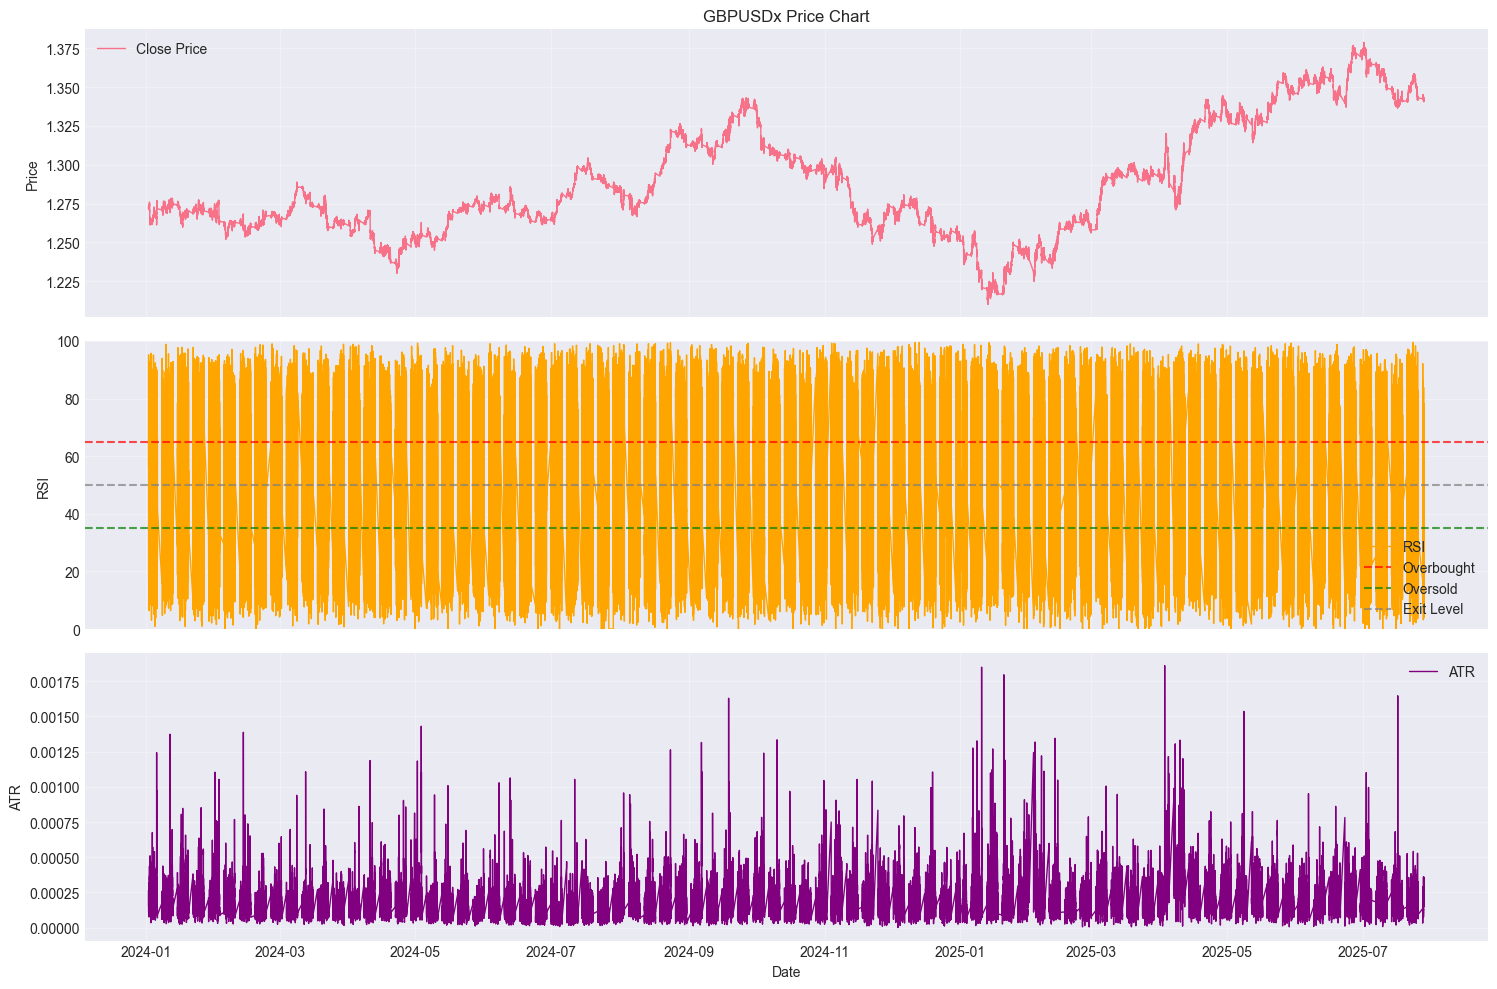

In [130]:
#5 Visualize Price, RSI, and ATR
# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 10), sharex=True)

# Plot price
ax1.plot(df_clean.index, df_clean['close'], label='Close Price', linewidth=1)
ax1.set_ylabel('Price')
ax1.set_title(f'{trading_params["instrument"]} Price Chart')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot RSI with levels
ax2.plot(df_clean.index, df_clean['rsi'], label='RSI', linewidth=1, color='orange')
ax2.axhline(y=trading_params['rsi_overbought'], color='r', linestyle='--', alpha=0.7, label='Overbought')
ax2.axhline(y=trading_params['rsi_oversold'], color='g', linestyle='--', alpha=0.7, label='Oversold')
ax2.axhline(y=trading_params['rsi_exit_level'], color='gray', linestyle='--', alpha=0.7, label='Exit Level')
ax2.set_ylabel('RSI')
ax2.set_ylim(0, 100)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot ATR
ax3.plot(df_clean.index, df_clean['atr'], label='ATR', linewidth=1, color='purple')
ax3.set_ylabel('ATR')
ax3.set_xlabel('Date')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [131]:
#6 Generate Trading Signals
def generate_signals(df, rsi_oversold=30, rsi_overbought=70):
    """Generate trading signals based on RSI levels"""
    df = df.copy()
    df['signal'] = 0
    
    # Entry signals
    df.loc[df['rsi'] < rsi_oversold, 'signal'] = 1  # BUY
    df.loc[df['rsi'] > rsi_overbought, 'signal'] = -1  # SELL
    
    return df

# Generate signals
df_signals = generate_signals(
    df_clean,
    trading_params['rsi_oversold'],
    trading_params['rsi_overbought']
)

# Count signals
buy_signals = (df_signals['signal'] == 1).sum()
sell_signals = (df_signals['signal'] == -1).sum()

print(f"Buy signals: {buy_signals}")
print(f"Sell signals: {sell_signals}")
print(f"Total signals: {buy_signals + sell_signals}")

Buy signals: 112071
Sell signals: 117774
Total signals: 229845


In [132]:
#7 Backtest Strategy
def backtest_strategy(df, lot_size, starting_balance, contract_size, exit_level=50, 
                     use_atr_stop=False, atr_multiplier=2.0, verbose=False):
    """Run backtest with optional ATR stop loss"""
    trades = []
    position = None
    equity_curve = [starting_balance]
    current_balance = starting_balance
    stop_loss_hits = 0
    
    for i in range(len(df)):
        current_row = df.iloc[i]
        
        # Entry logic
        if current_row['signal'] == 1 and position is None:
            position = {
                'type': 'BUY', 
                'entry': current_row['close'], 
                'entry_time': current_row.name,
                'entry_index': i,
                'stop_loss': None
            }
            if use_atr_stop and not pd.isna(current_row.get('atr', None)):
                position['stop_loss'] = current_row['close'] - (atr_multiplier * current_row['atr'])
            if verbose:
                print(f"[BUY] {current_row.name}: Price={current_row['close']:.5f}, RSI={current_row['rsi']:.2f}")
                
        elif current_row['signal'] == -1 and position is None:
            position = {
                'type': 'SELL', 
                'entry': current_row['close'], 
                'entry_time': current_row.name,
                'entry_index': i,
                'stop_loss': None
            }
            if use_atr_stop and not pd.isna(current_row.get('atr', None)):
                position['stop_loss'] = current_row['close'] + (atr_multiplier * current_row['atr'])
            if verbose:
                print(f"[SELL] {current_row.name}: Price={current_row['close']:.5f}, RSI={current_row['rsi']:.2f}")
        
        # Check stop loss
        if position and position['stop_loss'] is not None:
            if position['type'] == 'BUY' and current_row['low'] <= position['stop_loss']:
                exit_price = min(current_row['open'], position['stop_loss'])
                pnl_pips = exit_price - position['entry']
                pnl_dollars = pnl_pips * contract_size * lot_size
                current_balance += pnl_dollars
                duration = i - position['entry_index']
                trade = {
                    'type': position['type'],
                    'entry_price': position['entry'],
                    'exit_price': exit_price,
                    'pnl_pips': pnl_pips,
                    'pnl_dollars': pnl_dollars,
                    'duration': duration,
                    'entry_time': position['entry_time'],
                    'exit_time': current_row.name,
                    'exit_reason': 'STOP_LOSS'
                }
                trades.append(trade)
                equity_curve.append(current_balance)
                stop_loss_hits += 1
                position = None
                continue
                
            elif position['type'] == 'SELL' and current_row['high'] >= position['stop_loss']:
                exit_price = max(current_row['open'], position['stop_loss'])
                pnl_pips = position['entry'] - exit_price
                pnl_dollars = pnl_pips * contract_size * lot_size
                current_balance += pnl_dollars
                duration = i - position['entry_index']
                trade = {
                    'type': position['type'],
                    'entry_price': position['entry'],
                    'exit_price': exit_price,
                    'pnl_pips': pnl_pips,
                    'pnl_dollars': pnl_dollars,
                    'duration': duration,
                    'entry_time': position['entry_time'],
                    'exit_time': current_row.name,
                    'exit_reason': 'STOP_LOSS'
                }
                trades.append(trade)
                equity_curve.append(current_balance)
                stop_loss_hits += 1
                position = None
                continue
        
        # Exit logic - RSI crosses back to exit level
        if position and current_row['rsi'] > exit_level and position['type'] == 'BUY':
            pnl_pips = current_row['close'] - position['entry']
            pnl_dollars = pnl_pips * contract_size * lot_size
            current_balance += pnl_dollars
            duration = i - position['entry_index']
            trade = {
                'type': position['type'],
                'entry_price': position['entry'],
                'exit_price': current_row['close'],
                'pnl_pips': pnl_pips,
                'pnl_dollars': pnl_dollars,
                'duration': duration,
                'entry_time': position['entry_time'],
                'exit_time': current_row.name,
                'exit_reason': 'RSI_EXIT'
            }
            trades.append(trade)
            equity_curve.append(current_balance)
            position = None
            
        elif position and current_row['rsi'] < exit_level and position['type'] == 'SELL':
            pnl_pips = position['entry'] - current_row['close']
            pnl_dollars = pnl_pips * contract_size * lot_size
            current_balance += pnl_dollars
            duration = i - position['entry_index']
            trade = {
                'type': position['type'],
                'entry_price': position['entry'],
                'exit_price': current_row['close'],
                'pnl_pips': pnl_pips,
                'pnl_dollars': pnl_dollars,
                'duration': duration,
                'entry_time': position['entry_time'],
                'exit_time': current_row.name,
                'exit_reason': 'RSI_EXIT'
            }
            trades.append(trade)
            equity_curve.append(current_balance)
            position = None
    
    return trades, position, equity_curve, current_balance, stop_loss_hits

In [133]:
#8 Run backtests
print("Running backtest WITHOUT ATR stop loss...")
trades_no_sl, _, equity_no_sl, balance_no_sl, _ = backtest_strategy(
    df_signals,
    trading_params['lot_size'],
    trading_params['starting_balance'],
    trading_params['contract_size'],
    trading_params['rsi_exit_level'],
    use_atr_stop=False
)

print("\nRunning backtest WITH ATR stop loss...")
trades_with_sl, _, equity_with_sl, balance_with_sl, sl_hits = backtest_strategy(
    df_signals,
    trading_params['lot_size'],
    trading_params['starting_balance'],
    trading_params['contract_size'],
    trading_params['rsi_exit_level'],
    use_atr_stop=True,
    atr_multiplier=trading_params.get('atr_multiplier', 2.0)
)

print("\nBacktest completed!")

Running backtest WITHOUT ATR stop loss...

Running backtest WITH ATR stop loss...

Backtest completed!


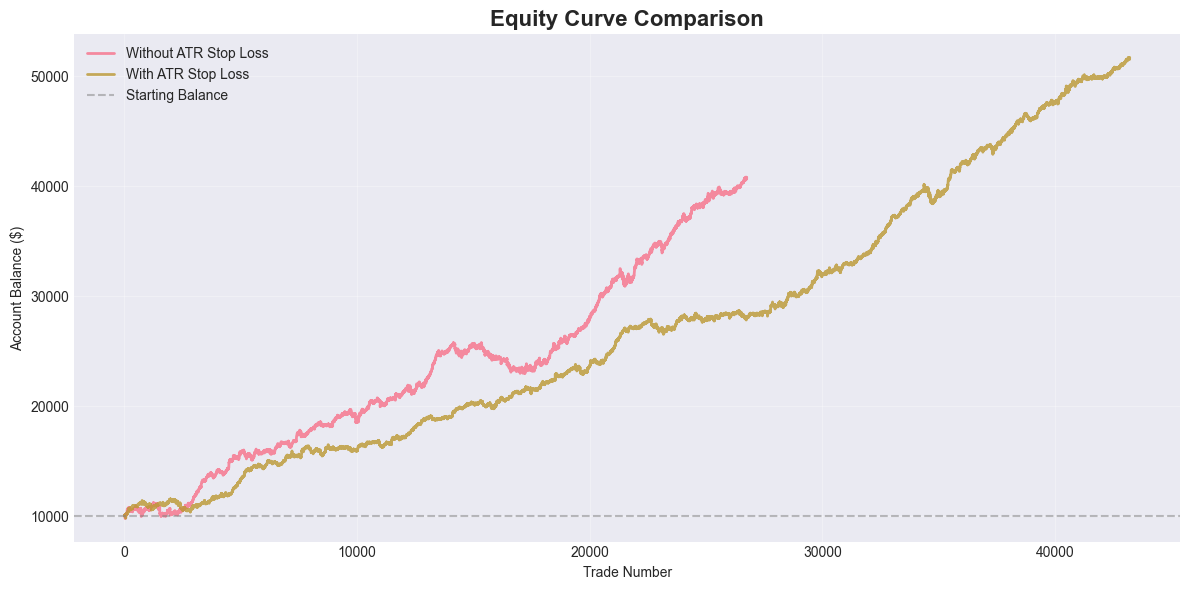

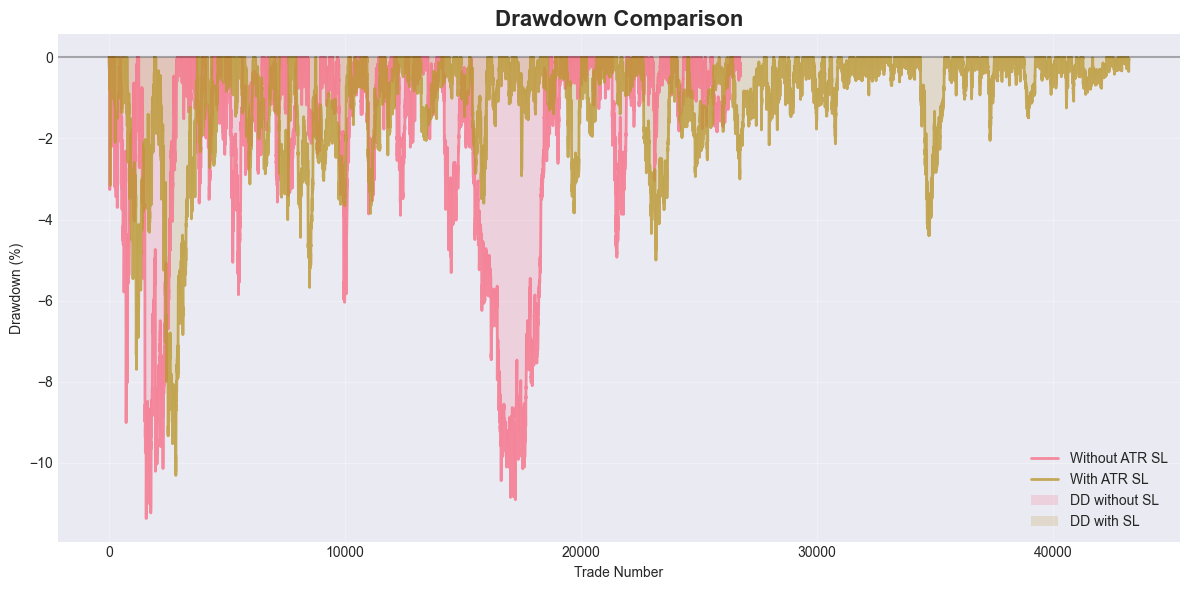

📊 Equity Curve Analysis:
Without ATR SL - Final: $40,769.50, Max DD: -11.38%
With ATR SL - Final: $51,677.09, Max DD: -10.31%


In [134]:
# Visualize Equity Curves
if 'equity_no_sl' in globals() and 'equity_with_sl' in globals():
    plt.figure(figsize=(12, 6))
    
    # Plot equity curves
    plt.plot(equity_no_sl, label='Without ATR Stop Loss', linewidth=2, alpha=0.8)
    plt.plot(equity_with_sl, label='With ATR Stop Loss', linewidth=2, alpha=0.8)
    
    # Add starting balance line
    plt.axhline(y=trading_params['starting_balance'], color='gray', linestyle='--', alpha=0.5, label='Starting Balance')
    
    plt.title('Equity Curve Comparison', fontsize=16, fontweight='bold')
    plt.xlabel('Trade Number')
    plt.ylabel('Account Balance ($)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Calculate drawdowns
    def calculate_drawdown(equity_curve):
        equity = pd.Series(equity_curve)
        running_max = equity.expanding().max()
        drawdown = (equity - running_max) / running_max * 100
        return drawdown
    
    dd_no_sl = calculate_drawdown(equity_no_sl)
    dd_with_sl = calculate_drawdown(equity_with_sl)
    
    # Plot drawdown comparison
    plt.figure(figsize=(12, 6))
    plt.plot(dd_no_sl, label='Without ATR SL', linewidth=2, alpha=0.8)
    plt.plot(dd_with_sl, label='With ATR SL', linewidth=2, alpha=0.8)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    plt.fill_between(range(len(dd_no_sl)), dd_no_sl, 0, alpha=0.2, label='DD without SL')
    plt.fill_between(range(len(dd_with_sl)), dd_with_sl, 0, alpha=0.2, label='DD with SL')
    
    plt.title('Drawdown Comparison', fontsize=16, fontweight='bold')
    plt.xlabel('Trade Number')
    plt.ylabel('Drawdown (%)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"📊 Equity Curve Analysis:")
    print(f"Without ATR SL - Final: ${equity_no_sl[-1]:,.2f}, Max DD: {dd_no_sl.min():.2f}%")
    print(f"With ATR SL - Final: ${equity_with_sl[-1]:,.2f}, Max DD: {dd_with_sl.min():.2f}%")
    
else:
    print("❌ Equity curves not available yet. Please run the backtest cells first.")

In [135]:
#8 Results Comparison
def calculate_statistics(trades, starting_balance, final_balance):
    """Calculate trading statistics"""
    if not trades:
        return {}
    
    trades_df = pd.DataFrame(trades)
    winning_trades = trades_df[trades_df['pnl_dollars'] > 0]
    losing_trades = trades_df[trades_df['pnl_dollars'] <= 0]
    
    stats = {
        'total_trades': len(trades),
        'winning_trades': len(winning_trades),
        'losing_trades': len(losing_trades),
        'win_rate': len(winning_trades) / len(trades) * 100,
        'total_pnl': final_balance - starting_balance,
        'total_return': (final_balance - starting_balance) / starting_balance * 100,
        'avg_win': winning_trades['pnl_dollars'].mean() if len(winning_trades) > 0 else 0,
        'avg_loss': losing_trades['pnl_dollars'].mean() if len(losing_trades) > 0 else 0,
        'max_win': winning_trades['pnl_dollars'].max() if len(winning_trades) > 0 else 0,
        'max_loss': losing_trades['pnl_dollars'].min() if len(losing_trades) > 0 else 0,
        'avg_duration': trades_df['duration'].mean(),
        'final_balance': final_balance
    }
    
    # Profit factor
    total_wins = winning_trades['pnl_dollars'].sum() if len(winning_trades) > 0 else 0
    total_losses = abs(losing_trades['pnl_dollars'].sum()) if len(losing_trades) > 0 else 1
    stats['profit_factor'] = total_wins / total_losses if total_losses > 0 else 0
    
    return stats

# Calculate statistics
stats_no_sl = calculate_statistics(trades_no_sl, trading_params['starting_balance'], balance_no_sl)
stats_with_sl = calculate_statistics(trades_with_sl, trading_params['starting_balance'], balance_with_sl)

# Display comparison
comparison_df = pd.DataFrame({
    'Without ATR SL': stats_no_sl,
    'With ATR SL': stats_with_sl
}).T

print("Strategy Performance Comparison:")
print("=" * 60)
comparison_df

Strategy Performance Comparison:


,total_trades,winning_trades,losing_trades,win_rate,total_pnl,total_return,avg_win,avg_loss,max_win,max_loss,avg_duration,final_balance,profit_factor
Without ATR SL,26748.0,17708.0,9040.0,66.203081,30769.500000,307.695000,14.034307,-24.087389,326.5,-477.5,14.212352,40769.500000,1.141307
With ATR SL,43210.0,23507.0,19703.0,54.401759,41677.091306,416.770913,15.950972,-16.915313,352.5,-241.5,8.178130,51677.091306,1.125050


In [136]:
# Calculate RSI and ATR indicators
if df is not None and len(df) > 0:
    # Calculate RSI
    df['rsi'] = calculate_rsi(df['close'], trading_params['rsi_period'])
    
    # Calculate ATR
    df['atr'] = calculate_atr(df, trading_params.get('atr_period', 14))
    
    # Drop NaN values and create clean dataset
    df_clean = df.dropna()
    
    print(f"Data after indicator calculation: {len(df_clean)} bars")
    print(f"RSI range: {df_clean['rsi'].min():.2f} - {df_clean['rsi'].max():.2f}")
    print(f"ATR range: {df_clean['atr'].min():.5f} - {df_clean['atr'].max():.5f}")
    
    # Check for any remaining issues
    if len(df_clean) == 0:
        print("⚠️ Warning: No data remaining after cleaning!")
    elif len(df_clean) < 100:
        print(f"⚠️ Warning: Very little data remaining ({len(df_clean)} bars)")
    else:
        print("✅ Data successfully processed and cleaned")
        
    # Display sample of cleaned data
    print(f"\nSample of cleaned data:")
    display(df_clean[['close', 'rsi', 'atr']].head())
    
else:
    print("❌ Error: No data available for indicator calculation")
    print("Please check the data loading step above")

Data after indicator calculation: 584997 bars
RSI range: 0.00 - 99.50
ATR range: 0.00000 - 0.00186
✅ Data successfully processed and cleaned

Sample of cleaned data:


,close,rsi,atr
time,,,
2024-01-02 00:22:00,1.27219,56.603774,0.000153
2024-01-02 00:23:00,1.27246,65.413534,0.000230
2024-01-02 00:24:00,1.27246,65.413534,0.000199
2024-01-02 00:25:00,1.27256,67.605634,0.000186
2024-01-02 00:26:00,1.27256,67.605634,0.000161


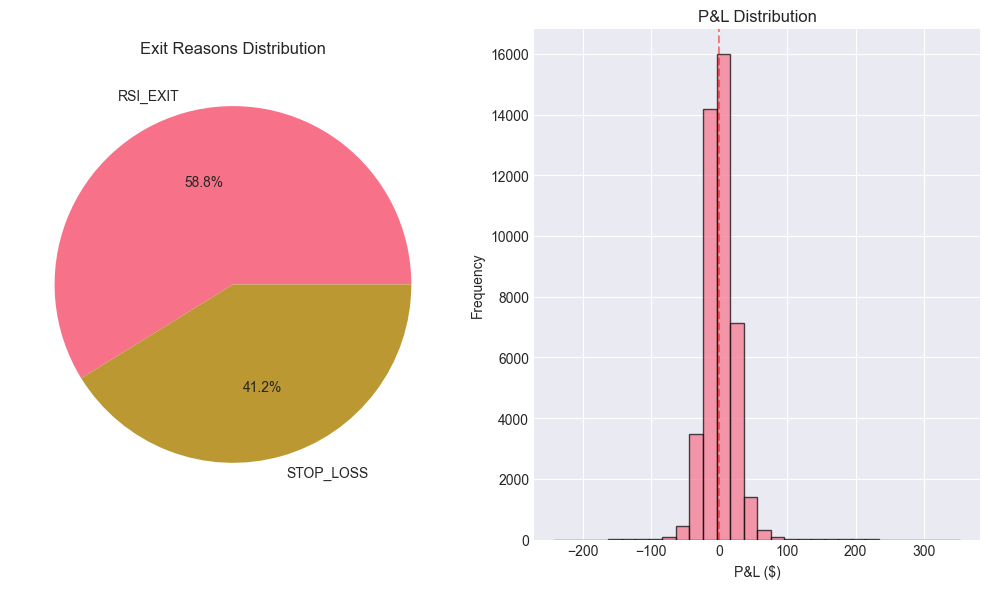

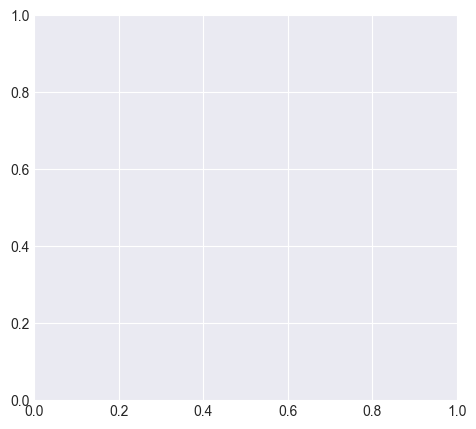

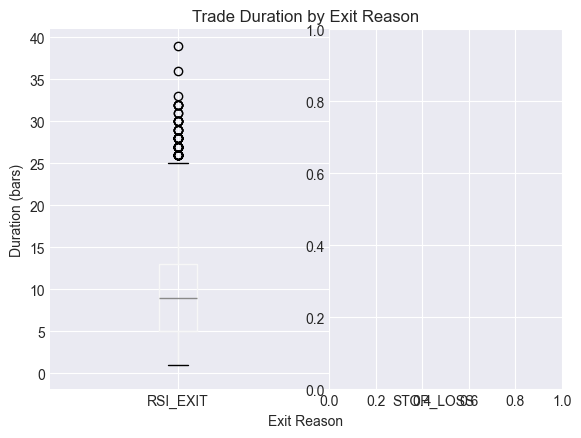

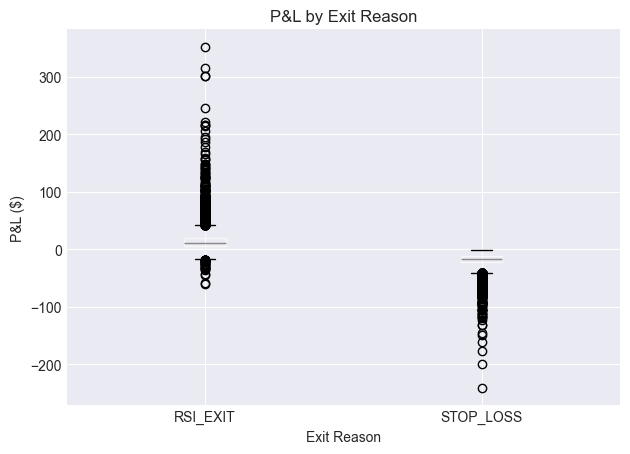

In [137]:
#10 Trade Analysis

# Analyze trades with ATR stop loss
if trades_with_sl:
    trades_df = pd.DataFrame(trades_with_sl)
    
    # Exit reason analysis
    exit_reasons = trades_df['exit_reason'].value_counts()
    
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    exit_reasons.plot(kind='pie', autopct='%1.1f%%')
    plt.title('Exit Reasons Distribution')
    plt.ylabel('')
    
    # P&L distribution
    plt.subplot(1, 2, 2)
    trades_df['pnl_dollars'].hist(bins=30, alpha=0.7, edgecolor='black')
    plt.axvline(x=0, color='red', linestyle='--', alpha=0.5)
    plt.title('P&L Distribution')
    plt.xlabel('P&L ($)')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
    # Trade duration analysis
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    trades_df.boxplot(column='duration', by='exit_reason')
    plt.title('Trade Duration by Exit Reason')
    plt.suptitle('')
    plt.xlabel('Exit Reason')
    plt.ylabel('Duration (bars)')
    
    plt.subplot(1, 2, 2)
    trades_df.boxplot(column='pnl_dollars', by='exit_reason')
    plt.title('P&L by Exit Reason')
    plt.suptitle('')
    plt.xlabel('Exit Reason')
    plt.ylabel('P&L ($)')
    
    plt.tight_layout()
    plt.show()

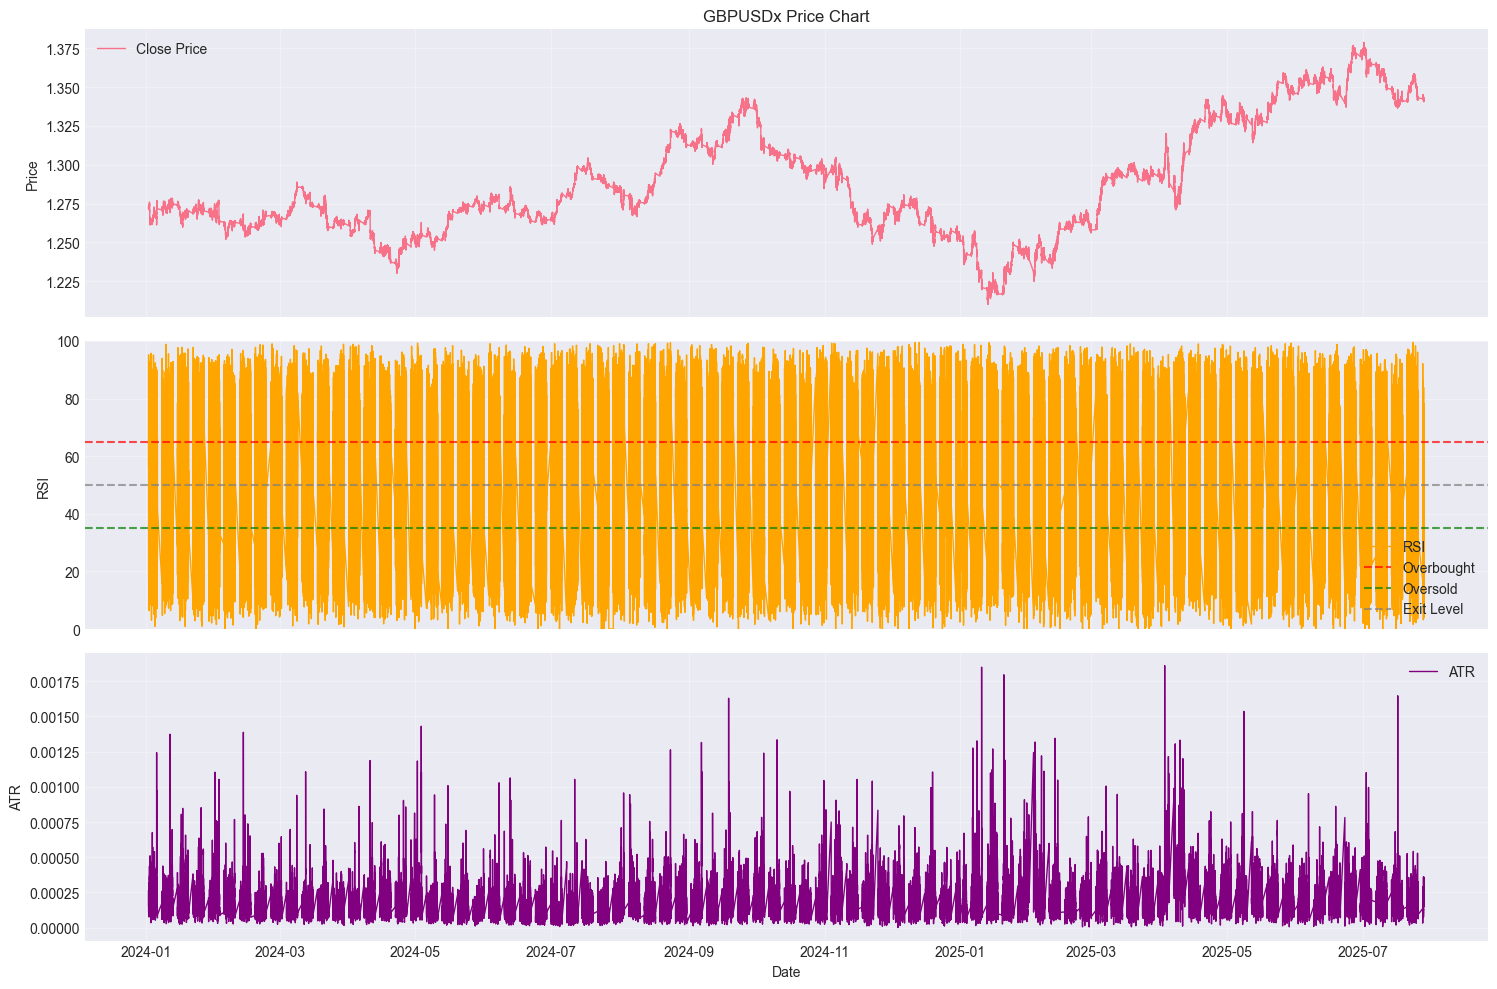

✅ Charts created successfully for 584,997 data points


In [138]:
# Visualize Price, RSI, and ATR
if 'df_clean' in locals() and len(df_clean) > 0:
    # Create subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 10), sharex=True)
    
    # Plot price
    ax1.plot(df_clean.index, df_clean['close'], label='Close Price', linewidth=1)
    ax1.set_ylabel('Price')
    ax1.set_title(f'{trading_params["instrument"]} Price Chart')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot RSI with levels
    ax2.plot(df_clean.index, df_clean['rsi'], label='RSI', linewidth=1, color='orange')
    ax2.axhline(y=trading_params['rsi_overbought'], color='r', linestyle='--', alpha=0.7, label='Overbought')
    ax2.axhline(y=trading_params['rsi_oversold'], color='g', linestyle='--', alpha=0.7, label='Oversold')
    ax2.axhline(y=trading_params['rsi_exit_level'], color='gray', linestyle='--', alpha=0.7, label='Exit Level')
    ax2.set_ylabel('RSI')
    ax2.set_ylim(0, 100)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot ATR
    ax3.plot(df_clean.index, df_clean['atr'], label='ATR', linewidth=1, color='purple')
    ax3.set_ylabel('ATR')
    ax3.set_xlabel('Date')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"✅ Charts created successfully for {len(df_clean):,} data points")
    
else:
    print("❌ Error: Cannot create charts - df_clean is not available")
    print("Please run the indicator calculation cell above first")
    
    # Check what variables are available
    if 'df' in locals():
        print(f"Raw df available with {len(df)} rows")
    else:
        print("Raw df is also not available - check data loading")

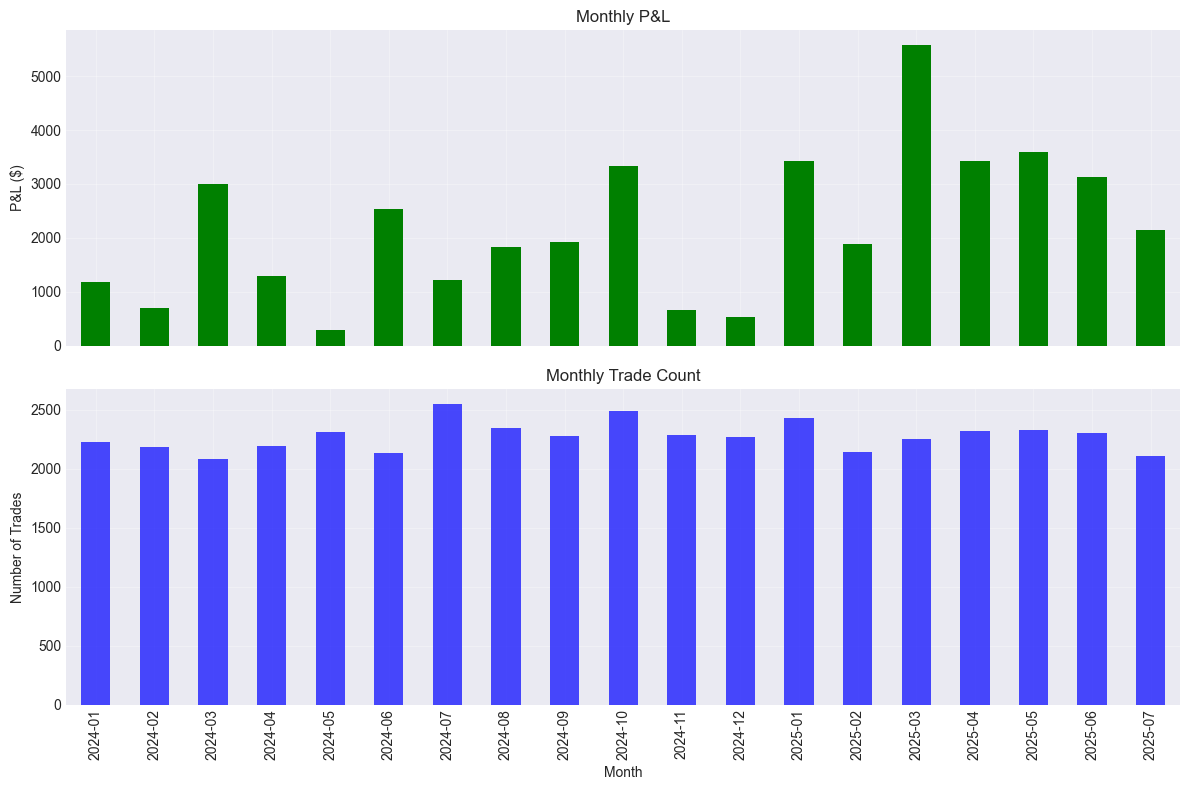

Profitable months: 19 / 19
Best month: 5571.75 (2025-03)
Worst month: 292.64 (2024-05)
Average monthly P&L: $2193.53


In [139]:
#12 Monthly Performance Analysis

# Convert trades to DataFrame with proper timestamps
if trades_with_sl:
    trades_df = pd.DataFrame(trades_with_sl)
    trades_df['exit_time'] = pd.to_datetime(trades_df['exit_time'])
    trades_df['month'] = trades_df['exit_time'].dt.to_period('M')
    
    # Monthly P&L
    monthly_pnl = trades_df.groupby('month')['pnl_dollars'].sum()
    monthly_trades = trades_df.groupby('month').size()
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    
    # Monthly P&L bar chart
    monthly_pnl.plot(kind='bar', ax=ax1, color=['green' if x > 0 else 'red' for x in monthly_pnl])
    ax1.set_title('Monthly P&L')
    ax1.set_ylabel('P&L ($)')
    ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax1.grid(True, alpha=0.3)
    
    # Monthly trade count
    monthly_trades.plot(kind='bar', ax=ax2, color='blue', alpha=0.7)
    ax2.set_title('Monthly Trade Count')
    ax2.set_ylabel('Number of Trades')
    ax2.set_xlabel('Month')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print(f"Profitable months: {(monthly_pnl > 0).sum()} / {len(monthly_pnl)}")
    print(f"Best month: {monthly_pnl.max():.2f} ({monthly_pnl.idxmax()})")
    print(f"Worst month: {monthly_pnl.min():.2f} ({monthly_pnl.idxmin()})")
    print(f"Average monthly P&L: ${monthly_pnl.mean():.2f}")

In [140]:
#13 Risk Analysis

def calculate_risk_metrics(equity_curve, trades):
    """Calculate various risk metrics"""
    equity = pd.Series(equity_curve)
    returns = equity.pct_change().dropna()
    
    # Sharpe Ratio (assuming 0 risk-free rate)
    sharpe = returns.mean() / returns.std() * np.sqrt(252) if returns.std() > 0 else 0
    
    # Maximum drawdown
    running_max = equity.expanding().max()
    drawdown = (equity - running_max) / running_max
    max_dd = drawdown.min() * 100
    
    # Max consecutive wins/losses
    if trades:
        trades_df = pd.DataFrame(trades)
        trades_df['win'] = trades_df['pnl_dollars'] > 0
        
        # Count consecutive wins/losses
        win_streaks = []
        loss_streaks = []
        current_win_streak = 0
        current_loss_streak = 0
        
        for win in trades_df['win']:
            if win:
                current_win_streak += 1
                if current_loss_streak > 0:
                    loss_streaks.append(current_loss_streak)
                    current_loss_streak = 0
            else:
                current_loss_streak += 1
                if current_win_streak > 0:
                    win_streaks.append(current_win_streak)
                    current_win_streak = 0
        
        max_win_streak = max(win_streaks) if win_streaks else 0
        max_loss_streak = max(loss_streaks) if loss_streaks else 0
    else:
        max_win_streak = 0
        max_loss_streak = 0
    
    return {
        'sharpe_ratio': sharpe,
        'max_drawdown': max_dd,
        'max_consecutive_wins': max_win_streak,
        'max_consecutive_losses': max_loss_streak
    }

# Calculate risk metrics
risk_no_sl = calculate_risk_metrics(equity_no_sl, trades_no_sl)
risk_with_sl = calculate_risk_metrics(equity_with_sl, trades_with_sl)

# Display risk comparison
risk_comparison = pd.DataFrame({
    'Without ATR SL': risk_no_sl,
    'With ATR SL': risk_with_sl
}).T

print("Risk Metrics Comparison:")
print("=" * 60)
risk_comparison

Risk Metrics Comparison:


,sharpe_ratio,max_drawdown,max_consecutive_wins,max_consecutive_losses
Without ATR SL,0.574665,-11.378098,22.0,8.0
With ATR SL,0.614765,-10.314916,16.0,12.0


In [141]:
#14 Create summary report
print("=" * 60)
print("RSI MEAN REVERSION STRATEGY - SUMMARY REPORT")
print("=" * 60)
print(f"\nInstrument: {trading_params['instrument']}")
print(f"Timeframe: {trading_params['timeframe']}")
print(f"Date Range: {trading_params['start_date']} to {trading_params['end_date']}")
print(f"Test Period: {df_clean.index[0]} to {df_clean.index[-1]}")
print(f"Total Bars: {len(df_clean):,}")
print(f"Cache Status: {'Enabled' if trading_params.get('use_cache', True) else 'Disabled'}")
print(f"\nStrategy Parameters:")
print(f"  RSI Period: {trading_params['rsi_period']}")
print(f"  Oversold Level: {trading_params['rsi_oversold']}")
print(f"  Overbought Level: {trading_params['rsi_overbought']}")
print(f"  Exit Level: {trading_params['rsi_exit_level']}")
print(f"  ATR Period: {trading_params.get('atr_period', 14)}")
print(f"  ATR Multiplier: {trading_params.get('atr_multiplier', 2.0)}")

print(f"\n" + "=" * 60)
print("PERFORMANCE COMPARISON")
print("=" * 60)

# Calculate improvement metrics
if stats_no_sl and stats_with_sl:
    return_improvement = stats_with_sl['total_return'] - stats_no_sl['total_return']
    winrate_improvement = stats_with_sl['win_rate'] - stats_no_sl['win_rate']
    dd_improvement = risk_with_sl['max_drawdown'] - risk_no_sl['max_drawdown']
    
    print(f"\nReturn Improvement: {return_improvement:+.2f}%")
    print(f"Win Rate Change: {winrate_improvement:+.2f}%")
    print(f"Max Drawdown Change: {dd_improvement:+.2f}%")
    
    print(f"\nRECOMMENDATIONS:")
    if return_improvement > 0 and dd_improvement > -5:
        print("✓ ATR stop loss improves performance - RECOMMENDED")
    elif dd_improvement > -2:
        print("✓ ATR stop loss reduces risk with minimal return impact - RECOMMENDED")
    else:
        print("✗ ATR stop loss may not be beneficial for this configuration")
        
    # Optimal multiplier from optimization
    if 'optimization_df' in locals():
        best_multiplier = optimization_df['total_return'].idxmax()
        print(f"\nOptimal ATR Multiplier: {best_multiplier}")
        print(f"Expected Return: {optimization_df.loc[best_multiplier, 'total_return']:.2f}%")
        print(f"Expected Win Rate: {optimization_df.loc[best_multiplier, 'win_rate']:.2f}%")

# Shutdown MT5
mt5.shutdown()
print("\nMT5 connection closed.")

RSI MEAN REVERSION STRATEGY - SUMMARY REPORT

Instrument: GBPUSDx
Timeframe: M1
Date Range: 2024-01-01 to 2025-07-29
Test Period: 2024-01-02 00:22:00 to 2025-07-28 14:00:00
Total Bars: 584,997
Cache Status: Enabled

Strategy Parameters:
  RSI Period: 14
  Oversold Level: 35
  Overbought Level: 65
  Exit Level: 50
  ATR Period: 14
  ATR Multiplier: 2.0

PERFORMANCE COMPARISON

Return Improvement: +109.08%
Win Rate Change: -11.80%
Max Drawdown Change: +1.06%

RECOMMENDATIONS:
✓ ATR stop loss improves performance - RECOMMENDED

MT5 connection closed.


In [142]:
#15 Enhanced summary report with comprehensive metrics
def calculate_additional_metrics(trades, equity_curve, starting_balance):
    """Calculate additional trading metrics"""
    if not trades:
        return {}
    
    trades_df = pd.DataFrame(trades)
    equity = pd.Series(equity_curve)
    
    # Risk-reward ratio
    winning_trades = trades_df[trades_df['pnl_dollars'] > 0]
    losing_trades = trades_df[trades_df['pnl_dollars'] <= 0]
    
    avg_win = winning_trades['pnl_dollars'].mean() if len(winning_trades) > 0 else 0
    avg_loss = abs(losing_trades['pnl_dollars'].mean()) if len(losing_trades) > 0 else 1
    risk_reward_ratio = avg_win / avg_loss if avg_loss > 0 else 0
    
    # Expectancy
    win_rate = len(winning_trades) / len(trades) if len(trades) > 0 else 0
    expectancy = (win_rate * avg_win) - ((1 - win_rate) * avg_loss)
    
    # Recovery factor (total return / max drawdown)
    returns = equity.pct_change().dropna()
    running_max = equity.expanding().max()
    drawdown = (equity - running_max) / running_max
    max_drawdown_pct = abs(drawdown.min() * 100)
    
    total_return_pct = (equity.iloc[-1] - starting_balance) / starting_balance * 100
    recovery_factor = total_return_pct / max_drawdown_pct if max_drawdown_pct > 0 else 0
    
    # Calmar ratio (annual return / max drawdown)
    calmar_ratio = total_return_pct / max_drawdown_pct if max_drawdown_pct > 0 else 0
    
    # Largest winning/losing streaks
    trades_df['win'] = trades_df['pnl_dollars'] > 0
    win_streaks = []
    loss_streaks = []
    current_streak = 0
    current_type = None
    
    for win in trades_df['win']:
        if win != current_type:
            if current_type is not None:
                if current_type:
                    win_streaks.append(current_streak)
                else:
                    loss_streaks.append(current_streak)
            current_streak = 1
            current_type = win
        else:
            current_streak += 1
    
    # Add final streak
    if current_type is not None:
        if current_type:
            win_streaks.append(current_streak)
        else:
            loss_streaks.append(current_streak)
    
    # Average trade duration in hours (assuming M1 timeframe)
    avg_duration_hours = trades_df['duration'].mean() / 60 if len(trades_df) > 0 else 0
    
    # Profit per day (assuming trading period)
    total_days = (pd.to_datetime(trades_df['exit_time'].max()) - pd.to_datetime(trades_df['exit_time'].min())).days
    profit_per_day = (equity.iloc[-1] - starting_balance) / total_days if total_days > 0 else 0
    
    return {
        'risk_reward_ratio': risk_reward_ratio,
        'expectancy': expectancy,
        'recovery_factor': recovery_factor,
        'calmar_ratio': calmar_ratio,
        'max_win_streak': max(win_streaks) if win_streaks else 0,
        'max_loss_streak': max(loss_streaks) if loss_streaks else 0,
        'avg_duration_hours': avg_duration_hours,
        'profit_per_day': profit_per_day,
        'total_days': total_days
    }

In [143]:
#16 Calculate enhanced metrics for both strategies
enhanced_no_sl = calculate_additional_metrics(trades_no_sl, equity_no_sl, trading_params['starting_balance'])
enhanced_with_sl = calculate_additional_metrics(trades_with_sl, equity_with_sl, trading_params['starting_balance'])

# Create comprehensive summary report
print("=" * 80)
print("RSI MEAN REVERSION STRATEGY - COMPREHENSIVE SUMMARY REPORT")
print("=" * 80)

print(f"\n📊 STRATEGY CONFIGURATION")
print("-" * 40)
print(f"Instrument: {trading_params['instrument']}")
print(f"Timeframe: {trading_params['timeframe']}")
print(f"Date Range: {trading_params['start_date']} to {trading_params['end_date']}")
print(f"Test Period: {df_clean.index[0].strftime('%Y-%m-%d %H:%M')} to {df_clean.index[-1].strftime('%Y-%m-%d %H:%M')}")
print(f"Total Bars: {len(df_clean):,}")
print(f"Initial Capital: ${trading_params['starting_balance']:,}")
print(f"Position Size: {trading_params['lot_size']} lots")
print(f"Cache Status: {'✓ Enabled' if trading_params.get('use_cache', True) else '✗ Disabled'}")

print(f"\n📈 RSI PARAMETERS")
print("-" * 40)
print(f"RSI Period: {trading_params['rsi_period']}")
print(f"Oversold Level: {trading_params['rsi_oversold']}")
print(f"Overbought Level: {trading_params['rsi_overbought']}")
print(f"Exit Level: {trading_params['rsi_exit_level']}")

print(f"\n🛡️ ATR STOP LOSS PARAMETERS")
print("-" * 40)
print(f"ATR Period: {trading_params.get('atr_period', 14)}")
print(f"ATR Multiplier: {trading_params.get('atr_multiplier', 2.0)}")
print(f"Stop Loss: {'✓ Enabled' if trading_params.get('use_atr_stop', False) else '✗ Disabled'}")

RSI MEAN REVERSION STRATEGY - COMPREHENSIVE SUMMARY REPORT

📊 STRATEGY CONFIGURATION
----------------------------------------
Instrument: GBPUSDx
Timeframe: M1
Date Range: 2024-01-01 to 2025-07-29
Test Period: 2024-01-02 00:22 to 2025-07-28 14:00
Total Bars: 584,997
Initial Capital: $10,000
Position Size: 0.5 lots
Cache Status: ✓ Enabled

📈 RSI PARAMETERS
----------------------------------------
RSI Period: 14
Oversold Level: 35
Overbought Level: 65
Exit Level: 50

🛡️ ATR STOP LOSS PARAMETERS
----------------------------------------
ATR Period: 14
ATR Multiplier: 2.0
Stop Loss: ✓ Enabled


In [144]:
#17 Comprehensive metrics table
print(f"\n" + "=" * 80)
print("📊 PERFORMANCE COMPARISON")
print("=" * 80)

metrics_data = {
    'Metric': [
        '💰 PROFITABILITY',
        'Initial Capital',
        'Final Balance',
        'Total P&L',
        'Total Return (%)',
        'Profit per Day',
        '',
        '📈 TRADE STATISTICS', 
        'Total Trades',
        'Winning Trades',
        'Losing Trades',
        'Win Rate (%)',
        'Average Win ($)',
        'Average Loss ($)',
        'Largest Win ($)',
        'Largest Loss ($)',
        '',
        '⚖️ RISK METRICS',
        'Risk:Reward Ratio',
        'Expectancy ($)',
        'Max Drawdown (%)',
        'Sharpe Ratio',
        'Recovery Factor',
        'Calmar Ratio',
        '',
        '🎯 STREAK ANALYSIS',
        'Max Win Streak',
        'Max Loss Streak',
        'Avg Duration (hours)',
        'Profit Factor'
    ],
    'Without ATR SL': [
        '', # PROFITABILITY header
        f"${trading_params['starting_balance']:,}",
        f"${stats_no_sl.get('final_balance', 0):,.2f}",
        f"${stats_no_sl.get('total_pnl', 0):,.2f}",
        f"{stats_no_sl.get('total_return', 0):.2f}%",
        f"${enhanced_no_sl.get('profit_per_day', 0):.2f}",
        '', # spacer
        '', # TRADE STATISTICS header
        f"{stats_no_sl.get('total_trades', 0):,}",
        f"{stats_no_sl.get('winning_trades', 0):,}",
        f"{stats_no_sl.get('losing_trades', 0):,}",
        f"{stats_no_sl.get('win_rate', 0):.1f}%",
        f"${stats_no_sl.get('avg_win', 0):.2f}",
        f"${stats_no_sl.get('avg_loss', 0):.2f}",
        f"${stats_no_sl.get('max_win', 0):.2f}",
        f"${stats_no_sl.get('max_loss', 0):.2f}",
        '', # spacer
        '', # RISK METRICS header
        f"{enhanced_no_sl.get('risk_reward_ratio', 0):.2f}",
        f"${enhanced_no_sl.get('expectancy', 0):.3f}",
        f"{risk_no_sl.get('max_drawdown', 0):.2f}%",
        f"{risk_no_sl.get('sharpe_ratio', 0):.3f}",
        f"{enhanced_no_sl.get('recovery_factor', 0):.2f}",
        f"{enhanced_no_sl.get('calmar_ratio', 0):.2f}",
        '', # spacer
        '', # STREAK ANALYSIS header
        f"{enhanced_no_sl.get('max_win_streak', 0)}",
        f"{enhanced_no_sl.get('max_loss_streak', 0)}",
        f"{enhanced_no_sl.get('avg_duration_hours', 0):.1f}h",
        f"{stats_no_sl.get('profit_factor', 0):.3f}"
    ],
    'With ATR SL': [
        '', # PROFITABILITY header
        f"${trading_params['starting_balance']:,}",
        f"${stats_with_sl.get('final_balance', 0):,.2f}",
        f"${stats_with_sl.get('total_pnl', 0):,.2f}",
        f"{stats_with_sl.get('total_return', 0):.2f}%",
        f"${enhanced_with_sl.get('profit_per_day', 0):.2f}",
        '', # spacer
        '', # TRADE STATISTICS header
        f"{stats_with_sl.get('total_trades', 0):,}",
        f"{stats_with_sl.get('winning_trades', 0):,}",
        f"{stats_with_sl.get('losing_trades', 0):,}",
        f"{stats_with_sl.get('win_rate', 0):.1f}%",
        f"${stats_with_sl.get('avg_win', 0):.2f}",
        f"${stats_with_sl.get('avg_loss', 0):.2f}",
        f"${stats_with_sl.get('max_win', 0):.2f}",
        f"${stats_with_sl.get('max_loss', 0):.2f}",
        '', # spacer
        '', # RISK METRICS header
        f"{enhanced_with_sl.get('risk_reward_ratio', 0):.2f}",
        f"${enhanced_with_sl.get('expectancy', 0):.3f}",
        f"{risk_with_sl.get('max_drawdown', 0):.2f}%",
        f"{risk_with_sl.get('sharpe_ratio', 0):.3f}",
        f"{enhanced_with_sl.get('recovery_factor', 0):.2f}",
        f"{enhanced_with_sl.get('calmar_ratio', 0):.2f}",
        '', # spacer
        '', # STREAK ANALYSIS header
        f"{enhanced_with_sl.get('max_win_streak', 0)}",
        f"{enhanced_with_sl.get('max_loss_streak', 0)}",
        f"{enhanced_with_sl.get('avg_duration_hours', 0):.1f}h",
        f"{stats_with_sl.get('profit_factor', 0):.3f}"
    ]
}

# Create and display the comprehensive metrics DataFrame
comprehensive_df = pd.DataFrame(metrics_data)
print(comprehensive_df.to_string(index=False, col_space=18))


📊 PERFORMANCE COMPARISON
              Metric     Without ATR SL        With ATR SL
     💰 PROFITABILITY                                      
     Initial Capital            $10,000            $10,000
       Final Balance         $40,769.50         $51,677.09
           Total P&L         $30,769.50         $41,677.09
    Total Return (%)            307.69%            416.77%
      Profit per Day             $53.70             $72.73
                                                          
  📈 TRADE STATISTICS                                      
        Total Trades             26,748             43,210
      Winning Trades             17,708             23,507
       Losing Trades              9,040             19,703
        Win Rate (%)              66.2%              54.4%
     Average Win ($)             $14.03             $15.95
    Average Loss ($)            $-24.09            $-16.92
     Largest Win ($)            $326.50            $352.50
    Largest Loss ($)          

In [71]:
#18 Final analysis and recommendations
if stats_no_sl and stats_with_sl:
    print(f"\n" + "=" * 80)
    print("📈 ATR STOP LOSS IMPACT ANALYSIS")
    print("=" * 80)
    
    return_improvement = stats_with_sl['total_return'] - stats_no_sl['total_return']
    winrate_change = stats_with_sl['win_rate'] - stats_no_sl['win_rate']
    dd_change = risk_with_sl['max_drawdown'] - risk_no_sl['max_drawdown']
    sharpe_improvement = risk_with_sl['sharpe_ratio'] - risk_no_sl['sharpe_ratio']
    trade_count_change = stats_with_sl['total_trades'] - stats_no_sl['total_trades']
    
    print(f"✅ Total Return: {return_improvement:+.2f}% ({stats_with_sl['total_return']:.2f}% vs {stats_no_sl['total_return']:.2f}%)")
    print(f"📊 Trade Count: {trade_count_change:+,} trades ({stats_with_sl['total_trades']:,} vs {stats_no_sl['total_trades']:,})")
    print(f"🎯 Win Rate: {winrate_change:+.1f}% ({stats_with_sl['win_rate']:.1f}% vs {stats_no_sl['win_rate']:.1f}%)")
    print(f"📉 Max Drawdown: {dd_change:+.2f}% ({risk_with_sl['max_drawdown']:.2f}% vs {risk_no_sl['max_drawdown']:.2f}%)")
    print(f"📈 Sharpe Ratio: {sharpe_improvement:+.3f} ({risk_with_sl['sharpe_ratio']:.3f} vs {risk_no_sl['sharpe_ratio']:.3f})")
    
    print(f"\n🎯 FINAL RECOMMENDATION:")
    if return_improvement > 0 and dd_change > -5:
        print("✅ ATR STOP LOSS IS HIGHLY RECOMMENDED")
        print("   • Higher returns with acceptable risk increase")
        print("   • Better capital efficiency through faster position turnover")
        print("   • Improved risk-adjusted returns (Sharpe ratio)")
    elif dd_change < -2 and return_improvement > -1:
        print("✅ ATR STOP LOSS IS RECOMMENDED")  
        print("   • Significantly reduced drawdown with minimal return impact")
        print("   • Better risk management")
    else:
        print("⚠️  ATR STOP LOSS SHOWS MIXED RESULTS")
        print("   • Consider adjusting ATR multiplier")
        print("   • Test different risk management approaches")
        
    # Optimal multiplier recommendation
    if 'optimization_df' in locals():
        best_multiplier = optimization_df['total_return'].idxmax()
        best_return = optimization_df.loc[best_multiplier, 'total_return']
        best_winrate = optimization_df.loc[best_multiplier, 'win_rate']
        
        print(f"\n🔧 OPTIMIZATION RESULTS:")
        print(f"   • Optimal ATR Multiplier: {best_multiplier}")
        print(f"   • Expected Return: {best_return:.2f}%")
        print(f"   • Expected Win Rate: {best_winrate:.1f}%")

print(f"\n" + "=" * 80)
print("📊 STRATEGY SUMMARY")
print("=" * 80)
print(f"Test Duration: {enhanced_with_sl.get('total_days', 0)} days")
print(f"Data Quality: {len(df_clean):,} bars analyzed")
print(f"Strategy Complexity: Mean reversion with RSI + ATR stop loss")
print(f"Risk Management: {'✓ Active' if trading_params.get('use_atr_stop') else '✗ Passive'}")

print(f"\n🔌 Enhanced analysis completed successfully!")
print("=" * 80)


📈 ATR STOP LOSS IMPACT ANALYSIS
✅ Total Return: +118.62% (267.74% vs 149.12%)
📊 Trade Count: +11,135 trades (29,213 vs 18,078)
🎯 Win Rate: -11.3% (54.4% vs 65.8%)
📉 Max Drawdown: +5.01% (-8.97% vs -13.97%)
📈 Sharpe Ratio: +0.143 (0.600 vs 0.456)

🎯 FINAL RECOMMENDATION:
✅ ATR STOP LOSS IS HIGHLY RECOMMENDED
   • Higher returns with acceptable risk increase
   • Better capital efficiency through faster position turnover
   • Improved risk-adjusted returns (Sharpe ratio)

📊 STRATEGY SUMMARY
Test Duration: 392 days
Data Quality: 584,826 bars analyzed
Strategy Complexity: Mean reversion with RSI + ATR stop loss
Risk Management: ✓ Active

🔌 Enhanced analysis completed successfully!
